In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from datetime import datetime
from collections import Counter
from matplotlib.patches import Patch
from scipy.stats import ttest_ind
from ChK.data_combined import *

# import ipfx

import os
# import pg8000

# from ipfx.dataset.create import create_ephys_data_set

# from ipfx.data_set_features import extract_data_set_features
# from ipfx.utilities import drop_failed_sweeps

# import seaborn as sns
# from ipfx.epochs import get_stim_epoch

# from ipfx.feature_extractor import (
#     SpikeFeatureExtractor, SpikeTrainFeatureExtractor
# )
# from ipfx.stimulus_protocol_analysis import RampAnalysis


In [ ]:
# Not merged with metadata
df_human, df_mouse_WB, df_mouse_VISp, df_m, df_H, df_QN = load_dataset(update=False, merge_metadata=False)

#### Merging with jem-metadata
There is no roi_major in the data I have, so I would have to merge with the jem_lims_metadata.xlsx to see the major and minor separated, however this reduces a bit the data (some cells for some reason are not in the jem_metadata file) The numbers drop like this:  Mouse WB (782 -> 718), mouse VISp (464 -> 400), human -although not necessary to merge as we are not looking for major in human rn (198 -> 145). I can always do the distribution but use the original one (without merging to metadata file)

In [ ]:
# Data merged with metdata (not for analysis as it reduces datapoints, just visualization egg. roi distribution)
df_human_meta, df_mouse_WB_meta, df_mouse_VISp_meta, _, _, _ = load_dataset(update=True, merge_metadata=True)

## Merge with ttype datasets per species

Instead of the old transcriptomics, use the mouse_VISp_tax_rsc384.csv that one has the VISp taxonomy instead of the Whole brain, this is the one used to compare with human (use tree_cluster column form the VISp taxonomy and merge with cluster_name from hodge_MvH, careful, there are underscores in one of those so they will have to be removed.)

The datasets for mouse transcriptomics has 21,560 cells when using whole brain taxonomy (df_mouse_tt_WB, file pulled directly from \\allen directory and gets updated) and 13,327 when using VISp taxonomy (df_tt_VISp, fixed dataset saved locally). The later only includes VISp neurons, so we will only use those ones.

## Number of cells in channel data densities file

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].bar(['Mouse','Human','NHP'],[df_m.shape[0], df_H.shape[0], df_QN.shape[0]], color = 'teal', alpha=0.6)
ax[0].set_ylabel('Number of cells')
ax[0].set_xlabel('Species')
ax[0].set_title(' No. cells with ch. recording')

ax[1].bar(['Mouse', 'Human'], [df_mouse_WB.shape[0],df_human.shape[0]], color = 'teal', alpha=0.6)
ax[1].set_ylabel('Number of cells')
ax[1].set_xlabel('Species')
ax[1].set_title('No. cells with ch. rec, WB tax and ephys')

ax[2].bar(['Mouse', 'Human'], [df_mouse_VISp.shape[0],df_human.shape[0]], color = 'teal', alpha=0.6)
ax[2].set_ylabel('Number of cells')
ax[2].set_xlabel('Species')
ax[2].set_title('No. cells with ch. rec, VISp tax and ephys')

Parameters mouse:
['cell', 'tot_-50', 'tot_-35', 'tot_-20', 'tot_-5', 'tot_10', 'tot_25',
       'tot_40', 'tot_55', 'tot_70_x', 'tot_85', 'tot_-70', 'tot_-55',
       'tot_-40', 'tot_-25', 'tot_-10', 'tot_5', 'tot_20', 'tot_35', 'tot_50',
       'fast_-50', 'fast_-35', 'fast_-20', 'fast_-5', 'fast_10', 'fast_25',
       'fast_40', 'fast_55', 'fast_70_x', 'fast_85', 'fast_-70', 'fast_-55',
       'fast_-40', 'fast_-25', 'fast_-10', 'fast_5', 'fast_20', 'fast_35',
       'fast_50', 'slow_-50', 'slow_-35', 'slow_-20', 'slow_-5', 'slow_10',
       'slow_25', 'slow_40', 'slow_55', 'slow_70', 'slow_85', 'sus_-50',
       'sus_-35', 'sus_-20', 'sus_-5', 'sus_10', 'sus_25', 'sus_30', 'sus_40',
       'sus_55', 'sus_70', 'sus_85', 'sus_0', 'sus_15', 'sus_30.1', 'sus_45',
       'sus_60', 'sus_75', 'sus_90', 'sus_105', 'sus_120', 'nonfast_-50',
       'nonfast_-35', 'nonfast_-20', 'nonfast_-5', 'nonfast_10', 'nonfast_25',
       'nonfast_40', 'nonfast_55', 'nonfast_70_x', 'nonfast_85', 'nonfast_-70',
       'nonfast_-55', 'nonfast_-40', 'nonfast_-25', 'nonfast_-10', 'nonfast_5',
       'nonfast_20', 'nonfast_35', 'nonfast_50', 'nonfast_-120',
       'nonfast_-105', 'nonfast_-90', 'nonfast_-75', 'nonfast_-60',
       'nonfast_-45', 'nonfast_-30', 'nonfast_-15', 'nonfast_0', 'tot_70_y',
       'fast_70_y', 'fast_total', 'nonfast_70_y', 'nonfast_total', 'jem-id_species',
       'rna_amplification_pass_fail', 'ttype',
       'supertype', 'subclass', 'ephys_qc', 'tau', 'avg_isi',
       'upstroke_downstroke_ratio_short_square', 'threshold_v_ramp',
       'peak_v_short_square', 'upstroke_downstroke_ratio_ramp', 'sag',
       'trough_t_ramp', 'slow_trough_v_ramp', 'vrest', 'has_pause',
       'trough_v_long_square', 'input_resistance_mohm',
       'trough_t_short_square', 'fast_trough_v_ramp', 'trough_t_long_square',
       'threshold_v_long_square', 'slow_trough_v_long_square', 'peak_t_ramp',
       'threshold_t_short_square', 'slow_trough_t_long_square',
       'input_access_resistance_ratio', 'fast_trough_t_long_square', 'ri',
       'threshold_t_long_square', 'threshold_v_short_square',
       'threshold_t_ramp', 'vm_for_sag', 'threshold_i_long_square',
       'threshold_i_short_square', 'slow_trough_t_ramp', 'peak_v_ramp',
       'fast_trough_v_short_square', 'fast_trough_t_short_square',
       'fast_trough_t_ramp', 'initial_access_resistance_mohm',
       'slow_trough_t_short_square', 'threshold_i_ramp',
       'slow_trough_v_short_square', 'peak_t_short_square',
       'trough_v_short_square', 'f_i_curve_slope', 'created_at',
       'peak_t_long_square', 'seal_gohm', 'trough_v_ramp', 'latency',
       'fast_trough_v_long_square', 'upstroke_downstroke_ratio_long_square',
       'Unnamed: 72', 'peak_v_long_square', 'adaptation'],

Parameters human:
['cell', 'tot_-50', 'tot_-35', 'tot_-20', 'tot_-5', 'tot_10', 'tot_25',
       'tot_40', 'tot_55', 'tot_70', 'tot_85', 'tot_-70', 'tot_-55', 'tot_-40',
       'tot_-25', 'tot_-10', 'tot_5', 'tot_20', 'tot_35', 'tot_50', 'fast_-50',
       'fast_-35', 'fast_-20', 'fast_-5', 'fast_10', 'fast_25', 'fast_40',
       'fast_55', 'fast_70', 'fast_85', 'fast_-70', 'fast_-55', 'fast_-40',
       'fast_-25', 'fast_-10', 'fast_5', 'fast_20', 'fast_35', 'fast_50',
       'slow_-50', 'slow_-35', 'slow_-20', 'slow_-5', 'slow_10', 'slow_25',
       'slow_40', 'slow_55', 'slow_70', 'slow_85', 'sus_-50', 'sus_-35',
       'sus_-20', 'sus_-5', 'sus_10', 'sus_25', 'sus_30', 'sus_40', 'sus_55',
       'sus_70', 'sus_85', 'sus_0', 'sus_15', 'sus_30.1', 'sus_45', 'sus_60',
       'sus_75', 'sus_90', 'sus_105', 'sus_120', 'nonfast_-50', 'nonfast_-35',
       'nonfast_-20', 'nonfast_-5', 'nonfast_10', 'nonfast_25', 'nonfast_40',
       'nonfast_55', 'nonfast_70', 'nonfast_85', 'nonfast_-70', 'nonfast_-55',
       'nonfast_-40', 'nonfast_-25', 'nonfast_-10', 'nonfast_5', 'nonfast_20',
       'nonfast_35', 'nonfast_50', 'nonfast_-120', 'nonfast_-105',
       'nonfast_-90', 'nonfast_-75', 'nonfast_-60', 'nonfast_-45',
       'nonfast_-30', 'nonfast_-15', 'nonfast_0', 'seq-name', 'cell_id',
       'cell_name_label','rna_amplification_pass_fail','cluster_Tree', 'subclass_Tree', 
       'class_Tree', 'cluster','UMAP_x', 'UMAP_y'
]


In [ ]:
# ROI (minor) - not merging with metadata
param = 'roi'

fig, ax = plt.subplots(1,2,figsize=(15,6), gridspec_kw={'wspace': 0.1},
                      width_ratios=[2.5,0.4] )
for i, species, classification, df_species in zip([0,1],['Mouse WB', 'Mouse VISp'],
                                            [param, param],
                                            [df_mouse_WB, df_mouse_VISp]):
    
    max_val = df_mouse_WB[param].value_counts().max() # Using same limit for both taxonomies (WB)
    ax[i].set_ylim(0, max_val * 1.05)
    
    ax[i].bar(df_species[classification].value_counts().index,
               df_species[classification].value_counts(), color = 'teal',
               alpha=0.6)
    ax[i].tick_params(axis='both', labelsize=8, rotation=90)
    ax[i].set_xlabel(f'{classification}')
    ax[i].set_ylabel('Number of cells')
    ax[i].set_title(f'{species} cells \nwith ch. rec and ephys')
    ax[i].grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('../results/roi_minor_counts_mouse_both_taxonomies.png', dpi=300, bbox_inches='tight')

In [ ]:
#ROI (major) - merging with metadata
param = 'jem-roi_major'

fig, ax = plt.subplots(1,2,figsize=(15,6), gridspec_kw={'wspace': 0.1},
                      width_ratios=[2.5,0.4] )
for i, species, classification, df_species in zip([0,1],['Mouse WB', 'Mouse VISp'],
                                            [param, param],
                                            [df_mouse_WB_meta, df_mouse_VISp_meta]): # using jem-metadata
    
    max_val = df_mouse_WB_meta[param].value_counts().max() # Using same limit for both taxonomies (WB)
    ax[i].set_ylim(0, max_val * 1.05)
    
    ax[i].bar(df_species[classification].value_counts().index,
               df_species[classification].value_counts(), color = 'teal',
               alpha=0.6)
    ax[i].tick_params(axis='both', labelsize=8, rotation=90)
    ax[i].set_xlabel(f'{classification}')
    ax[i].set_ylabel('Number of cells')
    ax[i].set_title(f'{species} cells \nwith ch. rec and ephys')
    ax[i].grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('../results/roi_major_counts_mouse_both_taxonomies.png', dpi=300, bbox_inches='tight')

In [ ]:
colors = [
    "dimgray", "darkgray", "whitesmoke", "mistyrose", "salmon", "tomato",
   "lightsalmon", "sienna", "peru",
    "firebrick", "maroon", "darkred", "red", "bisque", "darkorange", "burlywood", "antiquewhite",
    "tan", "navajowhite", "blanchedalmond", "papayawhip", "moccasin", "orange", "wheat", "oldlace",
    "floralwhite", "darkgoldenrod", "cornsilk", "gold", "lemonchiffon", "khaki", "palegoldenrod",
    "darkkhaki", "ivory", "beige", "lightyellow", "lightgoldenrodyellow", "olive", "yellow",
    "olivedrab", "yellowgreen", "darkolivegreen", "greenyellow", "chartreuse", "lawngreen", "honeydew",
    "darkseagreen", "palegreen", "lightgreen", "forestgreen", "limegreen", "darkgreen", "seagreen",
    "mediumseagreen", "springgreen", "mintcream", "mediumspringgreen", "aquamarine", "turquoise",
    "lightseagreen", "mediumturquoise", "cadetblue", "powderblue", "lightblue", "deepskyblue",
    "lightskyblue", "skyblue", "steelblue", "aliceblue", "dodgerblue", "lightslategray",
    "lightslategrey", "slategray", "lightsteelblue", "cornflowerblue", "royalblue", "ghostwhite",
    "lavender", "midnightblue", "navy", "slateblue",
    "darkslateblue", "mediumslateblue", "rebeccapurple", "blueviolet", "indigo", "darkorchid",
    "darkviolet", "mediumorchid", "thistle", "plum", "violet", "purple", "darkmagenta", "fuchsia",
    "magenta", "orchid", "mediumvioletred", "palevioletred", "lightpink"
]

In [ ]:
# Roi subclass distribution - with metadata
param = 'jem-roi_major'
stack_param = 'subclass'
categories = df_mouse_WB_meta[param].unique()

dict_test = {}
for cat in categories:
    if cat != 'VISp':
        test_df = df_mouse_WB_meta[df_mouse_WB_meta[param] == cat]
        dict_test[cat] = test_df[stack_param].value_counts()
    
df_plot = pd.DataFrame(dict_test).T.fillna(0)



n_colors = df_plot.shape[1] 
cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors, N=n_colors)

colors = [cmap(i / n_colors) for i in range(n_colors)]


df_plot.plot(kind='bar', stacked=True, figsize=(14, 7), color=colors)
plt.ylabel('Counts')
plt.title(f'{stack_param} distribution by {param}')
plt.legend(title=f'{stack_param}', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.savefig(f'../results/stacked_barplot_{stack_param}_by_roi_major.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Roi supertype distribution - with metadata
param = 'jem-roi_major'
stack_param = 'supertype'
categories = df_mouse_WB_meta[param].unique()

dict_test = {}
for cat in categories:
    if cat != 'VISp':
        test_df = df_mouse_WB_meta[df_mouse_WB_meta[param] == cat]
        dict_test[cat] = test_df[stack_param].value_counts()
    
df_plot = pd.DataFrame(dict_test).T.fillna(0)



n_colors = df_plot.shape[1]  
cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors, N=n_colors)


colors = [cmap(i / n_colors) for i in range(n_colors)]

df_plot.plot(kind='bar', stacked=True, figsize=(16, 9.5), color=colors)
plt.ylabel('Counts')
plt.title(f'{stack_param} distribution by {param}')
plt.legend(title=f'{stack_param}', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=3)
plt.tight_layout()
plt.savefig(f'../results/stacked_barplot_{stack_param}_by_roi_major.png', dpi=300, bbox_inches='tight')
plt.show()

### Heatmap roi vs subclass - maybe easier to see

In [ ]:
# Roi supertype distribution - with metadata
# Parameters
param = 'jem-roi_major'
stack_param = 'supertype'

# Filter out 'VISp' if you want to exclude it
df_filtered = df_mouse_WB_meta[df_mouse_WB_meta[param] != 'VISp']

# Create a contingency table (counts per category combination)
heatmap_data = pd.crosstab(df_filtered[param], df_filtered[stack_param])

# Plot heatmap
plt.figure(figsize=(25, 10))  # Set figure size
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='Blues', 
            annot_kws={"size":8}, cbar=False)  # No colorbar, show counts
plt.title(f'Heatmap of {stack_param} counts by {param}')
plt.ylabel(param)
plt.xlabel(stack_param)
plt.tight_layout()
plt.savefig(f'../results/heatmap_{stack_param}_by_{param}_no_colorbar.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# Roi subclass distribution - with metadata
# Parameters
param = 'jem-roi_major'
stack_param = 'subclass'

# Filter out 'VISp' if you want to exclude it
df_filtered = df_mouse_WB_meta[df_mouse_WB_meta[param] != 'VISp']

# Create a contingency table (counts per category combination)
heatmap_data = pd.crosstab(df_filtered[param], df_filtered[stack_param])

# Plot heatmap
plt.figure(figsize=(20, 10))  # Set figure size
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='Blues', 
            annot_kws={"size":9}, cbar=False)  # No colorbar, show counts
plt.title(f'Heatmap of {stack_param} counts by {param}')
plt.ylabel(param)
plt.xlabel(stack_param)
plt.tight_layout()
plt.savefig(f'../results/heatmap_{stack_param}_by_{param}_no_colorbar.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
classification_m = 'subclass' # 'ttype','supertype', 'subclass'
classification_h = 'tree_subclass' # 'tree_cluster', 'tree_subclass', 'tree_class'

fig, ax = plt.subplots(1,2,figsize=(10,7), gridspec_kw={'wspace': 0.35},
                      width_ratios= [2,0.8] )
for i, species, classification, df_species in zip([0,1],['Mouse', 'Human'],
                                            [classification_m, classification_h],
                                            [df_mouse_WB, df_human]):
    
    ax[i].barh(df_species[classification].value_counts().index,
               df_species[classification].value_counts(), color = 'teal',
               alpha=0.6)
    ax[i].tick_params(axis='both', labelsize=8)
    ax[i].set_xlabel('Number of cells')
    ax[i].set_ylabel(f'{classification}')
    ax[i].set_title(f'{species} cells with ch. rec and ephys, using WB tax')

In [ ]:
classification_m = 'subclass_Tree_label' # cluster_Tree_label, class_Tree_label

classification_h = 'tree_subclass' # 'tree_cluster', 'tree_subclass', 'tree_class'

fig, ax = plt.subplots(1,2,figsize=(10,7), gridspec_kw={'wspace': 0.35},
                      width_ratios= [2,0.8] )
for i, species, classification, df_species in zip([0,1],['Mouse', 'Human'],
                                            [classification_m, classification_h],
                                            [df_mouse_VISp, df_human]):
    
    ax[i].barh(df_species[classification].value_counts().index,
               df_species[classification].value_counts(), color = 'teal',
               alpha=0.6)
    ax[i].tick_params(axis='both', labelsize=8)
    ax[i].set_xlabel('Number of cells')
    ax[i].set_ylabel(f'{classification}')
    ax[i].set_title(f'{species} cells with ch. rec and ephys, using VISp tax')

### Samples for the dashboard

#### Scatterplots of columns

In [ ]:
plt.scatter(df_mouse_WB['tot_70'], df_mouse_WB['upstroke_downstroke_ratio_ramp'], color = 'teal', alpha=0.6)
plt.show()
plt.scatter(df_human['tot_70'], df_human['upstroke_downstroke_ratio_ramp'], color = 'teal', alpha=0.6)

## Homology analysis

### Total, slow and fast 70 currents by homology cluster.
Using df_human and df_mouse_VISp_homol

In [ ]:
df_dict_hom = pd.read_excel('../data/hodge_MvH_homology_mapping.xlsx')
df_mouse_VISp_hom = pd.merge(left = df_mouse_VISp, left_on = 'tree_cluster',
                    right = df_dict_hom, right_on = 'cluster_name', how = 'inner')

#### 9 VISp clusters are not in the homology dictionary, reducing the number of mouse cells from 464 to 358.

In [ ]:
# Cluster values from VISp that are not in the homology dictionary 
clusters_mouse_VISp= df_mouse_VISp['tree_cluster'].unique()

cluster_in_homol = np.array([cluster in df_dict_hom['cluster_name'].values for cluster in clusters_mouse_VISp])

print(Counter(cluster_in_homol)[True], ' Cluster in the dict,',
      Counter(cluster_in_homol)[False], ' Cluster not in the dict\n')

print(f'VISp clusters not in homol dict:\n', clusters_mouse_VISp[~cluster_in_homol], '\n')
print(f'This reduces the mouse data from {df_mouse_VISp.shape[0]}, to {df_mouse_VISp_hom.shape[0]} cells')

### Total 70 - mouse vs human

In [ ]:
df_human['homol_cluster']
df_mouse_VISp_hom['homol_cluster']

In [ ]:
df_dict_hom['homol_cluster'].unique()

In [ ]:
hom_cluster = 'Exc L5/6 IT 2' #df_dict_hom['homol_cluster'].unique()[6] #'Exc L2/3 IT'
human_cluster = df_human[df_human['homol_cluster']==hom_cluster]

In [ ]:
light_teal = (0/255, 128/255, 128/255, 0.4)

In [ ]:
# Prueba
rows = 1
cols = 2

fig, ax = plt.subplots(rows,cols,figsize=(8, 5))

for i, species, df_species, color_sp in zip([0,1], ['Mouse', 'Human'],
                                            [df_mouse_VISp_hom, df_human],
                                            ['powderblue', 'bisque']):
    
    sp_cluster = df_species[df_species['homol_cluster']==hom_cluster]
    
    data_to_plot = [sp_cluster[sp_cluster['cluster_name'] == cluster]['tot_70'].dropna().values 
                    for cluster in sp_cluster['cluster_name'].unique()]

    box = ax[i].boxplot(data_to_plot, patch_artist=True,
                    medianprops=dict(color='darkorange', linewidth=2))

    for box_element in box['boxes']:
        box_element.set_facecolor(color_sp) 
        box_element.set_edgecolor('black')  
        box_element.set_linewidth(1) 

    # Scatter plot to show individual data points
    for k, cluster in enumerate(sp_cluster['cluster_name'].unique(), start=1):
        cluster_data = sp_cluster[sp_cluster['cluster_name'] == cluster]['tot_70'].dropna().values
        ax[i].scatter([k] * len(cluster_data), cluster_data,
                        color=f'{color_sp}', alpha=0.6, zorder=3)  # zorder asegura que los puntos estén encima

    ax[i].set_xticklabels(sp_cluster['cluster_name'].unique(),
                            rotation=45, ha='right')
    
    ax[i].set_title(f'{species} {hom_cluster}', fontsize=16)
    ax[i].set_xlabel('Cluster Name', fontsize=12)
    ax[i].set_ylabel('Tot_70', fontsize=12)

    plt.tight_layout()

plt.show()

### Plot average clusters by species for each hom clus

In [ ]:
def plot_homol_clus_avg(hom_cluster, save_fig=False, value_to_plot='tot_70', 
                        plt_show=True, figsize=(4, 4), leg=True, title_str=None,
                        ylabel=None):
    try:
        
        mouse_hom_cluster = df_mouse_VISp_hom[df_mouse_VISp_hom['homol_cluster'] == hom_cluster]
        human_hom_cluster = df_human[df_human['homol_cluster'] == hom_cluster]

        species = ['Mouse', 'Human']
        positions = np.arange(2)
        cluster_map = {sp: pos for sp, pos in zip(species, positions)}

        # List for boxplot
        box_data = []
        box_positions = []
        colors = []

        # Add mouse data
        mouse_cluster_data = df_mouse_VISp_hom[(df_mouse_VISp_hom['homol_cluster'] == hom_cluster)][value_to_plot].dropna().values
        human_cluster_data = df_human[(df_human['homol_cluster'] == hom_cluster)][value_to_plot].dropna().values

        for sp, data, color in zip(species, [mouse_cluster_data, human_cluster_data], ['powderblue', 'bisque']):
            if len(data) > 0:
                box_data.append(data)
                box_positions.append(cluster_map[sp])
                colors.append(color)

        if not box_data:  # If box_data is empty
            raise ValueError(f"There is no data for cluster {hom_cluster}")

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=figsize)

        # Draw the boxplot
        box = ax.boxplot(box_data, positions=box_positions, patch_artist=True, 
                        medianprops=dict(color='black', linewidth=2),
                        flierprops=dict(marker='o', color='white', markersize=0, 
                                        markerfacecolor='white', markeredgewidth=0),
                        widths=0.4)

        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')
            patch.set_linewidth(1)
            
        # Scatter plot to show individual data points
        jitter_strength = 0.1  # Random jitter strength
        legend_patches = []

        for sp, data in zip(cluster_map.keys(), [mouse_cluster_data, human_cluster_data]):
            pos = cluster_map[sp]
            
            if len(data) > 0:
                jitter_x = pos + np.random.uniform(-jitter_strength, jitter_strength, size=len(data))
                ax.scatter(jitter_x, data, color=colors[species.index(sp)], 
                        alpha=0.6, edgecolors='black', zorder=3)
                
                # Legend
                if leg == True:
                    legend_patches.append(plt.Line2D([0], [0], marker='s', color='w', 
                                                    markerfacecolor=colors[species.index(sp)], 
                                                    markersize=10, label=sp))

        if leg == True:
            ax.legend(handles=legend_patches, loc='upper right')
        # ax.set_xlabel('Species', fontsize=12)
        
        if type(ylabel) == str:
            ax.set_ylabel(ylabel, fontsize=12)
        else:
            ax.set_ylabel(value_to_plot, fontsize=12)
        ax.set_xticks([])

        
        if type(title_str) == str:
            ax.set_title(title_str, fontsize=13, fontweight='bold')
        else:
            ax.set_title(f'{value_to_plot} ({hom_cluster})', fontsize=13, fontweight='bold')
              
        # Y-axis limits
        lim_y_max = max(max(sublist) for sublist in box_data)
        lim_y_min = min(min(sublist) for sublist in box_data)    
        y_range = lim_y_max - lim_y_min

        ax.set_ylim(lim_y_min - 0.2*y_range, lim_y_max + 0.2*y_range)
        lim_y = lim_y_max + (0.055*y_range)
        
        
        # t-test
        t_stat, p_value = ttest_ind(mouse_cluster_data, 
                                    human_cluster_data,
                                    equal_var=False)  # Welch’s t-test
        #text box
        if p_value < 0.001:
            plt.text(0.25, lim_y, f'p < 0.001',
                 fontsize=12, fontweight='bold')
        elif p_value < 0.01:
            plt.text(0.25, lim_y, f'p < 0.01',
                 fontsize=12, fontweight='bold')
        elif p_value < 0.05:
            plt.text(0.25, lim_y, f'p < 0.05',
                 fontsize=12, fontweight='bold')
 

        plt.tight_layout()

        if save_fig == True:
            # if not os.path.exists(f'../results/avg_clust/{value_to_plot}'):
            #     os.makedirs(f'../results/avg_clust/{value_to_plot}')
            #     print(f"Directory '../results/avg_clust/{value_to_plot}' created.")
            
            # # Save the figure
            # hom_cluster_name = hom_cluster.replace("/", "_")
            # plt.savefig(f'../results/avg_clust/{value_to_plot}/boxplot_{hom_cluster_name}.png', dpi=300, bbox_inches='tight')
            # print(f'Figure saved as ../results/avg_clust/{value_to_plot}/boxplot_{hom_cluster_name}.png')
            
            
            # save by cluster folder
            hom_cluster_name = hom_cluster.replace("/", "_")
            if not os.path.exists(f'../results/avg_clust/by_clust/{hom_cluster_name}'):
                os.makedirs(f'../results/avg_clust/by_clust/{hom_cluster_name}')
                print(f"Directory '../results/avg_clust/by_clust/{hom_cluster_name}' created.")
            
            # Save the figure
            plt.savefig(f'../results/avg_clust/by_clust/{hom_cluster_name}/boxplot_{value_to_plot}.png', dpi=300, bbox_inches='tight')
            print(f'Figure saved as ../results/avg_clust/by_clust/{hom_cluster_name}/boxplot_{value_to_plot}.png')
            
        if plt_show == True:
            plt.show()
        else:
            plt.close(fig)
            
    except Exception as e:
            print(f'Error: {e}')

In [ ]:
# Distribution cells per cluster per species
ticks_x = []
n = 0
clust_to_plot = [15,30]
fig, ax = plt.subplots(figsize=(9, 6))

ax.set_xlim(0, 36)

for cluster in df_dict_hom['homol_cluster'].unique()[clust_to_plot[0]:clust_to_plot[1]]:
    try:
        ax.barh(n-0.15, df_mouse_VISp_hom['homol_cluster'].value_counts()[cluster], 
               color = 'teal', alpha=0.5, height=0.3, label='Mouse')
    except:
        ax.barh(n-0.15, 0, color = 'teal', alpha=0.5, height=0.3, label='Mouse')
        print(f'Error: {cluster} not in mouse data')
    
    
    try:
        ax.barh(n+0.15, df_human['homol_cluster'].value_counts()[cluster], 
               color = 'salmon', alpha=0.5, height=0.3, label='Human')
        
    except:
        ax.barh(n+0.15, 0, color = 'salmon', alpha=0.5, height=0.3, label='Human')
        print(f'Error: {cluster} not in human data')
        
    # ticks
    n += 1
    ticks_x.append(cluster)
    ax.set_yticks(np.arange(len(ticks_x)))
    ax.set_yticklabels(ticks_x, rotation=0, ha='right')
    # grid
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    legend_elements = [Patch(facecolor='teal', label='Mouse', alpha=0.5),
                       Patch(facecolor='salmon', label='Human', alpha=0.5)]

    plt.legend(handles=legend_elements, loc='best')
    ax.set_title('Number of cells per cluster', fontsize=12)
    ax.set_xlabel('Number of cells', fontsize=12)
    plt.tight_layout()
plt.savefig(f'../results/cluster_counts{clust_to_plot[0]}-{clust_to_plot[1]}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

#### Avg - Tot_70 all clusters

In [ ]:
for hom_cluster in df_dict_hom['homol_cluster'].unique():
    plot_homol_clus_avg(hom_cluster, save_fig=False, value_to_plot='tot_70', plt_show=True,
                        figsize=(4, 3.2))

#### Avg - Fast_70 all clusters

In [ ]:
for hom_cluster in df_dict_hom['homol_cluster'].unique():
    plot_homol_clus_avg(hom_cluster, save_fig=True, value_to_plot='fast_70', plt_show=True,
                        figsize=(4, 3.2))

#### Avg - Nonfast_70 all clusters

In [ ]:
for hom_cluster in df_dict_hom['homol_cluster'].unique():
    plot_homol_clus_avg(hom_cluster, save_fig=True, value_to_plot='nonfast_70', plt_show=False,
                        figsize=(4, 3.2))

### Individual clusters by species

In [ ]:
def plot_homol_clus(hom_cluster, save_fig=False, value_to_plot='tot_70', plt_show=True):
    try:
        # Obtain unique clusters for the given homology cluster
        mouse_clusters = df_mouse_VISp_hom[df_mouse_VISp_hom['homol_cluster'] == hom_cluster]['cluster_name'].unique()
        human_clusters = df_human[df_human['homol_cluster'] == hom_cluster]['cluster_name'].unique()
        all_clusters = list(mouse_clusters) + list(human_clusters)  # Combine both lists

        # Asign positions for clusters
        positions = np.arange(1, len(all_clusters) + 1)
        cluster_map = {cluster: pos for cluster, pos in zip(all_clusters, positions)}

        # List for boxplot
        box_data = []
        box_positions = []
        colors = []

        # Add mouse data
        for cluster in mouse_clusters:
            cluster_data = df_mouse_VISp_hom[(df_mouse_VISp_hom['homol_cluster'] == hom_cluster) & 
                                            (df_mouse_VISp_hom['cluster_name'] == cluster)][value_to_plot].dropna().values
            if len(cluster_data) > 0:
                box_data.append(cluster_data)
                box_positions.append(cluster_map[cluster])
                colors.append('powderblue')

        # Add human data
        for cluster in human_clusters:
            cluster_data = df_human[(df_human['homol_cluster'] == hom_cluster) & 
                                    (df_human['cluster_name'] == cluster)][value_to_plot].dropna().values
            if len(cluster_data) > 0:
                box_data.append(cluster_data)
                box_positions.append(cluster_map[cluster])
                colors.append('bisque')

        # Verify if there are any data to plot
        if not box_data:  # If box_data is empty
            raise ValueError(f"There is no data for cluster {hom_cluster}")

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(6, 5))

        # Draw the boxplot
        box = ax.boxplot(box_data, positions=box_positions, patch_artist=True, 
                        medianprops=dict(color='black', linewidth=2),
                        flierprops=dict(marker='o', color='white', markersize=0, 
                                        markerfacecolor='white', markeredgewidth=0))

        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')
            patch.set_linewidth(1)

        # Scatter plot to show individual data points
        jitter_strength = 0.1  # Random jitter strength

        for cluster, pos in cluster_map.items():
            cluster_data_mouse = df_mouse_VISp_hom[(df_mouse_VISp_hom['homol_cluster'] == hom_cluster) & 
                                                (df_mouse_VISp_hom['cluster_name'] == cluster)][value_to_plot].dropna().values
            cluster_data_human = df_human[(df_human['homol_cluster'] == hom_cluster) & 
                                        (df_human['cluster_name'] == cluster)][value_to_plot].dropna().values

            if len(cluster_data_mouse) > 0:
                jitter_x_mouse = pos + np.random.uniform(-jitter_strength, 0, size=len(cluster_data_mouse))
                ax.scatter(jitter_x_mouse, cluster_data_mouse, color='powderblue', 
                        alpha=0.6, edgecolors='black', zorder=3)

            if len(cluster_data_human) > 0:
                jitter_x_human = pos + np.random.uniform(0, jitter_strength, size=len(cluster_data_human))
                ax.scatter(jitter_x_human, cluster_data_human, color='bisque', 
                        alpha=0.6, edgecolors='black', zorder=3)

        # Set x-ticks and labels
        ax.set_xticks(positions)
        ax.set_xticklabels(all_clusters, rotation=45, ha='right')

        # Set y-axis limits
        ax.set_title(f'Comparison of {hom_cluster}', fontsize=16)
        ax.set_xlabel('Cluster Name', fontsize=12)
        ax.set_ylabel(value_to_plot, fontsize=12)

        # Legend
        legend_patches = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='powderblue', markersize=10, label='Mouse'),
                        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='bisque', markersize=10, label='Human')]
        ax.legend(handles=legend_patches, loc='upper right')

        plt.tight_layout()
        
        if save_fig == True:
            if not os.path.exists(f'../results/by_cluster/{value_to_plot}'):
                os.makedirs(f'../results/by_cluster/{value_to_plot}')
                print(f"Directory '../results/by_cluster/{value_to_plot}' created.")
            
            # Save the figure
            hom_cluster_name = hom_cluster.replace("/", "_")
            plt.savefig(f'../results/by_cluster/{value_to_plot}/boxplot_{hom_cluster_name}.png', dpi=300, bbox_inches='tight')
            print(f'Figure saved as ../results/by_cluster/{value_to_plot}/boxplot_{hom_cluster_name}.png')
        if plt_show == True:
            plt.show()
        else:
            plt.close(fig)

    except Exception as e:
        print(f'Error: {e}')


#### Tot_70 all clusters

In [ ]:
for cluster_num in range(len(df_dict_hom['homol_cluster'].unique())):
    plot_homol_clus(hom_cluster = df_dict_hom['homol_cluster'].unique()[cluster_num], 
                    value_to_plot='tot_70',
                    save_fig=True, 
                    plt_show=False)

In [ ]:
# all_clusters = df_dict_hom['homol_cluster'].unique()
# # fig, ax = plt.subplots(len(all_clusters), 1, figsize=(6, 5*len(all_clusters)))
# fig, ax = plt.subplots(figsize=(6, 5))

# for i_clus, hom_cluster in zip(range(len(all_clusters)), all_clusters):
    
#     try:
#         # Obtener clusters únicos combinados
#         mouse_clusters = df_mouse_VISp_hom[df_mouse_VISp_hom['homol_cluster'] == hom_cluster]['cluster_name'].unique()
#         human_clusters = df_human[df_human['homol_cluster'] == hom_cluster]['cluster_name'].unique()
#         all_clusters = list(mouse_clusters) + list(human_clusters)  # Combinar en orden

#         # Asignar posiciones consecutivas
#         positions = np.arange(1, len(all_clusters) + 1)
#         cluster_map = {cluster: pos for cluster, pos in zip(all_clusters, positions)}

#         # Listas para boxplots
#         box_data = []
#         box_positions = []
#         colors = []

#         # Agregar datos de ratón
#         for cluster in mouse_clusters:
#             cluster_data = df_mouse_VISp_hom[(df_mouse_VISp_hom['homol_cluster'] == hom_cluster) & 
#                                             (df_mouse_VISp_hom['cluster_name'] == cluster)]['tot_70'].dropna().values
#             if len(cluster_data) > 0:
#                 box_data.append(cluster_data)
#                 box_positions.append(cluster_map[cluster])
#                 colors.append('powderblue')

#         # Agregar datos de humano
#         for cluster in human_clusters:
#             cluster_data = df_human[(df_human['homol_cluster'] == hom_cluster) & 
#                                     (df_human['cluster_name'] == cluster)]['tot_70'].dropna().values
#             if len(cluster_data) > 0:
#                 box_data.append(cluster_data)
#                 box_positions.append(cluster_map[cluster])
#                 colors.append('bisque')

#         # Dibujar boxplots
#         box = ax[i_clus].boxplot(box_data, positions=box_positions, patch_artist=True, 
#                         medianprops=dict(color='darkorange', linewidth=2),
#                         flierprops=dict(marker='o', color='white', markersize=0, 
#                                         markerfacecolor='white', markeredgewidth=0))


#         for patch, color in zip(box['boxes'], colors):
#             patch.set_facecolor(color)
#             patch.set_edgecolor('black')
#             patch.set_linewidth(1)

#         # Scatter plot con **jitter aleatorio**
#         jitter_strength = 0.1  # Controla el rango del desplazamiento aleatorio

#         for cluster, pos in cluster_map.items():
#             cluster_data_mouse = df_mouse_VISp_hom[(df_mouse_VISp_hom['homol_cluster'] == hom_cluster) & 
#                                                 (df_mouse_VISp_hom['cluster_name'] == cluster)]['tot_70'].dropna().values
#             cluster_data_human = df_human[(df_human['homol_cluster'] == hom_cluster) & 
#                                         (df_human['cluster_name'] == cluster)]['tot_70'].dropna().values

#             if len(cluster_data_mouse) > 0:
#                 jitter_x_mouse = pos + np.random.uniform(-jitter_strength, 0, size=len(cluster_data_mouse))
#                 ax[i_clus].scatter(jitter_x_mouse, cluster_data_mouse, color='powderblue', 
#                         alpha=0.6, edgecolors='black', zorder=3)

#             if len(cluster_data_human) > 0:
#                 jitter_x_human = pos + np.random.uniform(0, jitter_strength, size=len(cluster_data_human))
#                 ax[i_clus].scatter(jitter_x_human, cluster_data_human, color='bisque', 
#                         alpha=0.6, edgecolors='black', zorder=3)

#         # Etiquetas en el eje X
#         ax[i_clus].set_xticks(positions)
#         ax[i_clus].set_xticklabels(all_clusters, rotation=45, ha='right')

#         # Títulos y etiquetas
#         ax[i_clus].set_title(f'Comparison of {hom_cluster}', fontsize=16)
#         ax[i_clus].set_xlabel('Cluster Name', fontsize=12)
#         ax[i_clus].set_ylabel('Tot_70', fontsize=12)

#         # Leyenda
#         legend_patches = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='powderblue', markersize=10, label='Mouse'),
#                         plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='bisque', markersize=10, label='Human')]
#         ax[i_clus].legend(handles=legend_patches, loc='upper right')

#         plt.tight_layout()
#         plt.show()
#     except:
#         print(f'Cluster {i_clus}{i_clus}: {hom_cluster} not found in dataframes')

#### Fast_70 all clusters

In [ ]:
for cluster_num in range(len(df_dict_hom['homol_cluster'].unique())):
    plot_homol_clus(hom_cluster = df_dict_hom['homol_cluster'].unique()[cluster_num], 
                    value_to_plot='fast_70',
                    save_fig=False,
                    plt_show=False) 

#### Nonfast_70 all clusters

In [ ]:
for cluster_num in range(len(df_dict_hom['homol_cluster'].unique())):
    plot_homol_clus(hom_cluster = df_dict_hom['homol_cluster'].unique()[cluster_num], 
                    value_to_plot='nonfast_70',
                    save_fig=False,
                    plt_show=True)

#### Slow and fast do not sum up to total, will use ratio of the sum.

In [ ]:
print('Total 70: ', df_human['tot_70'][0])
print('Slow 70 + Fast 70: ', df_human['slow_70'][0] + df_human['fast_70'][0])
print('Nonfast 70 + Fast: ', df_human['nonfast_70'][0] + df_human['fast_70'][0])

# Ephys features per cluster
- Sag
- Rheobase
- Upstroke/downstroke ratio short square
- ISI

In [ ]:
# Sag
for hom_cluster in df_dict_hom['homol_cluster'].unique():
    plot_homol_clus_avg(hom_cluster, save_fig=True, value_to_plot='sag', plt_show=False,
                        figsize=(2.5, 4), leg=False, title_str='Sag') 

In [ ]:
# upstroke_downstroke_ratio_short_square
for hom_cluster in df_dict_hom['homol_cluster'].unique():
    plot_homol_clus_avg(hom_cluster, save_fig=True, value_to_plot='upstroke_downstroke_ratio_short_square', plt_show=False,
                        figsize=(2.5, 4), leg=False, title_str='up/downstroke short sq', ylabel='upstroke/downstroke ratio') 

In [ ]:
# avg_isi
for hom_cluster in df_dict_hom['homol_cluster'].unique():
    plot_homol_clus_avg(hom_cluster, save_fig=True, value_to_plot='avg_isi', plt_show=False,
                        figsize=(2.5, 4), leg=False, title_str='avg_isi', ylabel='avg_isi') 

In [ ]:
# rheobase (threshold_i_long_square)
for hom_cluster in df_dict_hom['homol_cluster'].unique():
    plot_homol_clus_avg(hom_cluster, save_fig=True, value_to_plot='threshold_i_long_square', plt_show=False,
                        figsize=(2.5, 4), leg=False, title_str='rheobase', ylabel='threshold_i_long_square') #3, 2.8

## Next steps
- Roi distribution for mouse (using the WB taxonomy??, before filtering by VISp taxonomy)
- Roi distribution by tttypes
- Literature review fot fast component
- Ratio slow/tot, fast/tot, create column and plot by subclass
- Add AHP ephys: trough_v_short_square, fast_trough_v_short_square, slow_trough_v_short_square.

In [ ]:
# AHP (trough_v_short_square)
for hom_cluster in df_dict_hom['homol_cluster'].unique():
    plot_homol_clus_avg(hom_cluster, save_fig=False, value_to_plot='trough_v_short_square', plt_show=False,
                        figsize=(2.5, 4), leg=False, title_str='trough_v_short_square', ylabel='AHP') 

In [ ]:
# AHP (trough_v_short_square)
for hom_cluster in df_dict_hom['homol_cluster'].unique():
    plot_homol_clus_avg(hom_cluster, save_fig=False, value_to_plot='fast_trough_v_short_square', plt_show=False,
                        figsize=(2.5, 4), leg=False, title_str='fast_trgh_shrt_sq', ylabel='AHP') 

In [ ]:
# AHP (trough_v_short_square)
for hom_cluster in df_dict_hom['homol_cluster'].unique():
    plot_homol_clus_avg(hom_cluster, save_fig=False, value_to_plot='slow_trough_v_short_square', plt_show=False,
                        figsize=(2.5, 4), leg=False, title_str='slow_trough_v_short_sq', ylabel='AHP') 

In [ ]:
# current
for hom_cluster in df_dict_hom['homol_cluster'].unique():
    plot_homol_clus_avg(hom_cluster, save_fig=False, value_to_plot='slow_trough_v_short_square', plt_show=False,
                        figsize=(2.5, 4), leg=False, title_str='slow_trough_v_short_sq', ylabel='AHP') 

In [111]:
df_mouse_VISp_hom_dat.shape, df_human.shape

((0, 822), (198, 178))

No data for Astrocyte
No data for Not identified
No data for Endothelial
No directory for Exc L2/3 IT plot not created


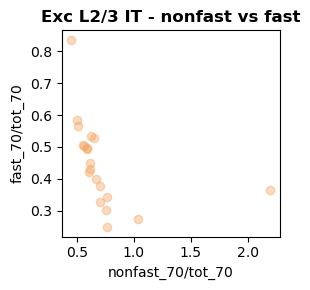

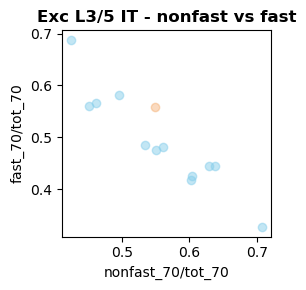

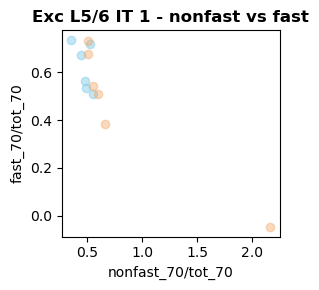

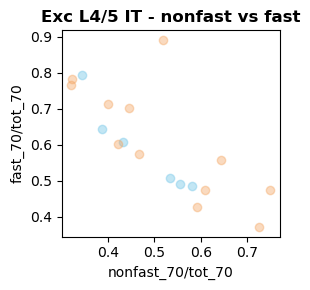

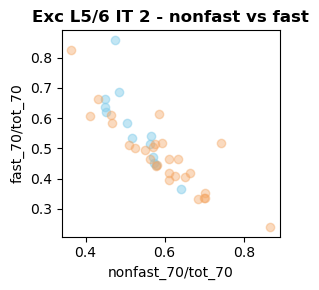

No data for Exc L5 PT
No data for Mixed (L5/6 IT 2,3)


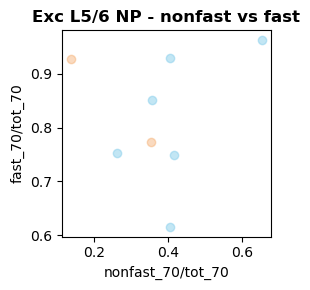

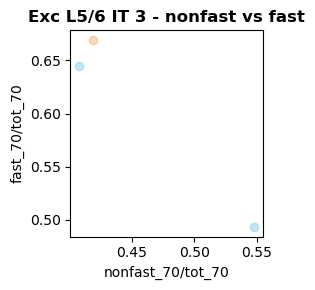

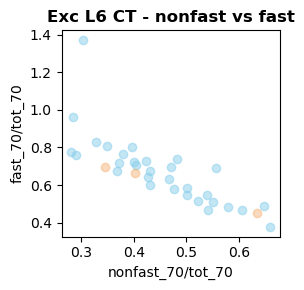

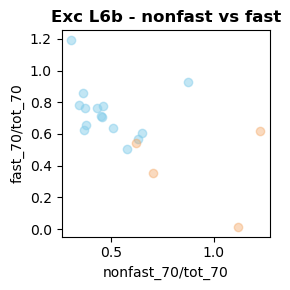

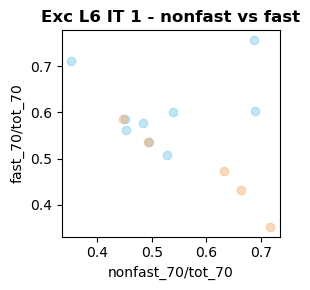

No directory for Exc L6 IT 2 plot not created


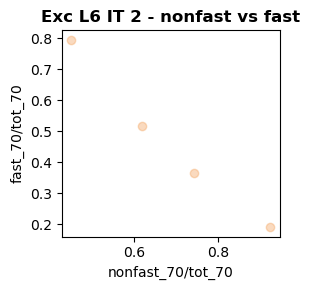

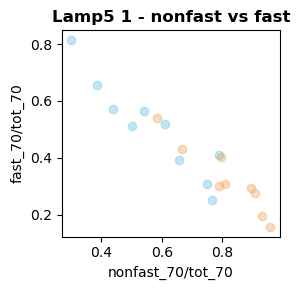

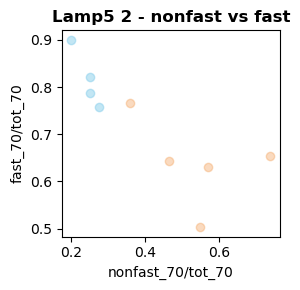

No directory for Pax6 plot not created
No directory for Vip 1 plot not created


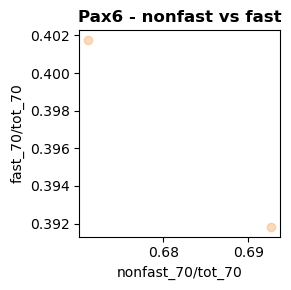

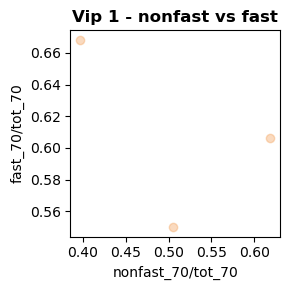

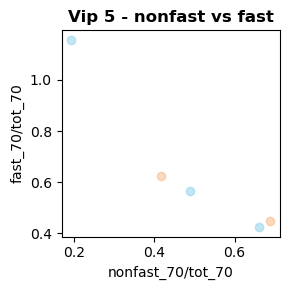

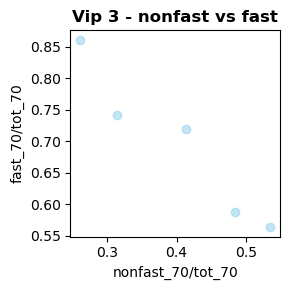

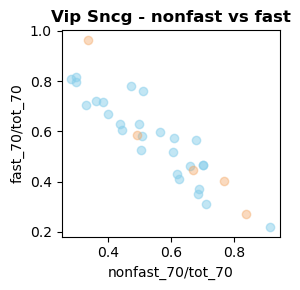

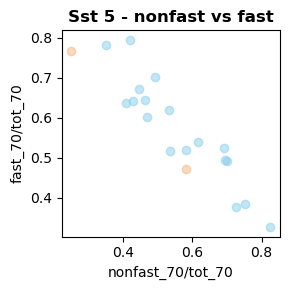

No directory for Vip 4 plot not created


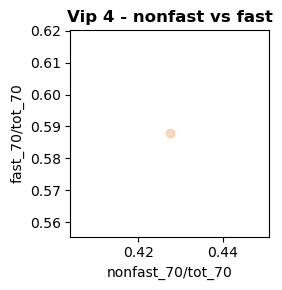

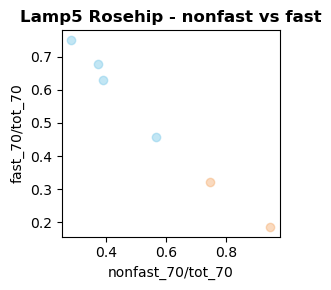

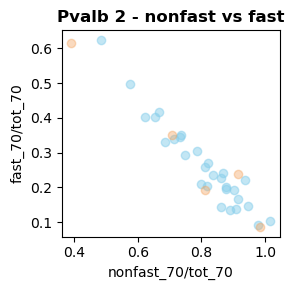

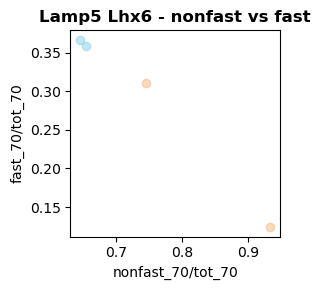

No directory for Mixed (Sst 5, Pvalb 2) plot not created
No data for Microglia/PVM
No data for Oligo


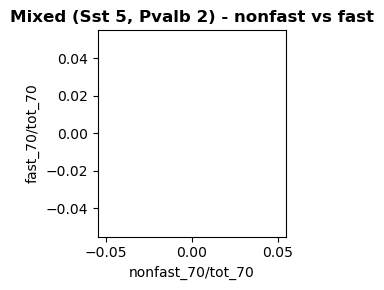

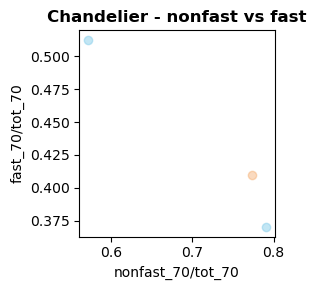

No data for OPC


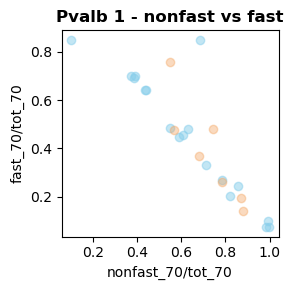

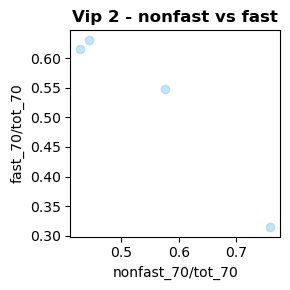

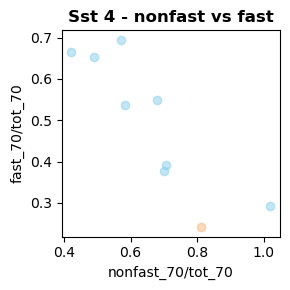

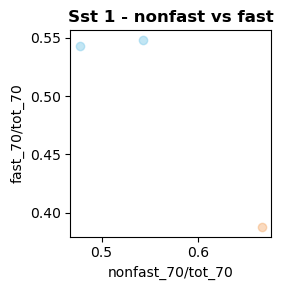

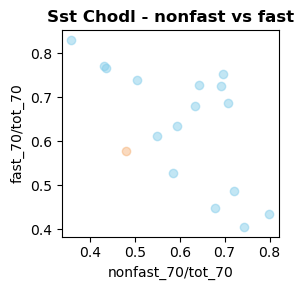

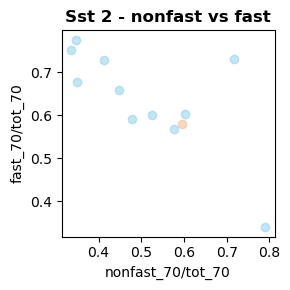

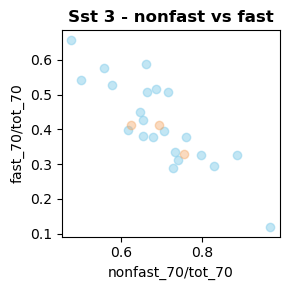

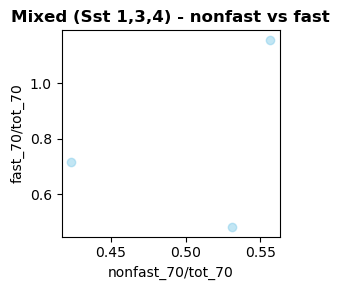

No data for Mixed (Vip 1,2,3,4)


In [117]:
for hom_cluster in df_dict_hom['homol_cluster'].unique():
    try:
        df_mouse_VISp_hom_dat = df_mouse_VISp_hom[df_mouse_VISp_hom['homol_cluster'] == hom_cluster]
        df_human_dat = df_human[df_human['homol_cluster'] == hom_cluster]
        
        if df_mouse_VISp_hom_dat.shape[0] == 0 and df_human_dat.shape[0] == 0:
            print(f'No data for {hom_cluster}')
            continue
        
        plt.figure(figsize=(3, 3))
        plt.scatter(df_mouse_VISp_hom_dat['nonfast_tot_70_ratio'], 
                    df_mouse_VISp_hom_dat['fast_tot_70_ratio'], 
                    color = 'skyblue', alpha=0.5) 
        
        plt.scatter(df_human_dat['nonfast_tot_70_ratio'], 
                    df_human_dat['fast_tot_70_ratio'], 
                    color = 'sandybrown', alpha=0.4) 
        
        plt.title(f'{hom_cluster} - nonfast vs fast', fontweight='bold')
        plt.xlabel('nonfast_70/tot_70')
        plt.ylabel('fast_70/tot_70')
        plt.tight_layout()
        
        hom_cluster_dir = hom_cluster.replace("/", "_")
        plt.savefig(f'../results/avg_clust/by_clust/{hom_cluster_dir}/fast_nonfast_ratio_{hom_cluster_dir}.png', dpi=300, bbox_inches='tight')
        plt.show()
    except:
        print(f'No directory for {hom_cluster} plot not created')
        continue
    

### Ratio slow/tot, fast/tot